# Homework 10: Neural Networks
by Yousif Khaireddin

**Due date**: April 28, Wednesday by 11:59pm


## Setup

To run and solve this assignment, you must have access to a working Jupyter Notebook installation. We recommend Google Colab. If you are already familiar with Jupyter and have your own installation, you may use it; however, you will have to tweak Colab-specific commands we've entered here (for example, file uploads).

To use Google Colab:

1. Download this `ipynb` file.
2. Navigate to https://colab.research.google.com/ and select `Upload` in the pop-up window.
3. Upload this file. It will then open in Colab.

The below statements assume that you have already followed these instructions. If you need help with Python syntax, NumPy, or Matplotlib, you might find Week 1 discussion material useful.

To run code in a cell or to render Markdown+LaTeX press Ctrl+Enter or "`Run`" button above. To edit any code or text cell, double-click on its content. Put your solution into boxes marked with **`[double click here to add a solution]`** and press Ctrl+Enter to render text. You can add cells via `+` sign at the top left corner.

**Submission instructions**: please upload your completed solution file as well as a scan of any handwritten answers to Gradescope by **April 28th at midnight**..

## **Question 1:** Useful Functions and Setup


In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading Dataset

Using the datasets module within torchvision, download the MNIST dataset.
1. Download both the training dataset as well as the testing dataset.
2. Using _torch.utils.data.random_split_ seperate the training dataset into 50000 training samples and 10000 validation samples 

In [ ]:
# Training and validation data
train_dataset = datasets.MNIST('./data', train  = True, download = True, transform=transforms.ToTensor()) # CODE
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000]) # CODE

# Testing data
test_dataset = datasets.MNIST('./data', train  = False, download = True, transform=transforms.ToTensor())# CODE

In [ ]:
print("Number of Training Samples:", len(train_dataset), sep='\t')
print("Number of Validation Samples:", len(val_dataset), sep='\t')
print("Number of Testing Samples:", len(test_dataset), sep='\t')

Number of Training Samples:	50000
Number of Validation Samples:	10000
Number of Testing Samples:	10000


Build your dataloaders using the datasets above. Make sure to use a batchsize of 64 and to shuffle your dataset.

In [ ]:
# Creating Dataloaders
from torch.utils.data import DataLoader
trainloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valloader = DataLoader(val_dataset, batch_size = 64, shuffle = True) # CODE
testloader = DataLoader(test_dataset, batch_size = 64, shuffle = True) # CODE

print("Number of Training Batches:", len(trainloader), sep='\t')
print("Number of Validation Batches:", len(valloader), sep='\t')
print("Number of Testing Batches:", len(testloader), sep='\t')

Number of Training Batches:	782
Number of Validation Batches:	157
Number of Testing Batches:	157


### Important functions

Complete the function `train(net, dataloader, criterion, optimizer)` which will train a given network for 1 whole epoch using a given dataloader.

This function will iterate through the dataloader, compute the network outputs, the loss, backpropagage to update the networks weights, and return the accuracy and average loss across the dataloader

Ensure to setup the network in training mode using the .train() attribute built by pytorch.

In [ ]:
def train(net, dataloader, criterion, optimizer):
    net = net.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    loss = 0.0
    
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        # CODE
        optimizer.zero_grad()
        
        # forward + backward + optimize
        # CODE
        outputs = net(inputs)
        loss_tr = criterion(outputs, labels)
        loss_tr.backward()
        optimizer.step()
        
        # store / calculate performance metrics (acc, loss)
        # CODE
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        correct_count += (predicted == labels).sum().item()
        loss += loss_tr.item() / labels.size(0)
        
    acc = 100 * correct_count / n_samples

    return acc, loss

Complete the function `evaluate(net, dataloader, criterion)` which will evauate a given network's performance across a given dataloader

This function will iterate through the dataloader, compute the network outputs, the loss, and return the accuracy and average loss across the dataloader.

Ensure to setup the network in validation mode using the .eval() attribute built by pytorch.

In [ ]:
def evaluate(net, dataloader, criterion):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    loss = 0.0
    
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # compute network predictions
        # CODE
        outputs = net(inputs)
        loss_tr = criterion(outputs, labels)

        # calculate performance metrics (acc, loss)
        # CODE
        _ , predicted = torch.max(outputs.data, 1)
        loss += loss_tr.item() / labels.size(0)
        n_samples += labels.size(0)
        correct_count += (predicted == labels).sum().item()

    acc = 100 * correct_count / n_samples

    return acc, loss

Complete the function `count_parameters(model)` which should count the number of trainable parameters in a network.

In [ ]:
from keras.models import Model
def count_parameters(model):

    count = sum(param.numel() for param in model.parameters()) # CODE

    return count

The following function will be used to create plots of your performance metrics.


In [ ]:
def plot_metrics(train_acc, train_loss, val_acc, val_loss):
    plt.figure()
    plt.plot(train_acc, 'g', label='Training Acc')
    plt.plot(val_acc, 'b', label='Validation Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(train_loss, 'g', label='Training Loss')
    plt.plot(val_loss, 'b', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

## **Question 2:** Dense Networks

**Note:**
In solving the following sections, it is possible very likely that your results do not match ours exactly. This is due to the randomization in initilizations. What is important is that they are within the margins we set when defining the problem. 

### Initial Performance

Recall from the discussion session, we provided you with the following fully connected (dense) network.


In [ ]:
class Dense(nn.Module):
    # What does your model contain
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)    # 10 classes
    
    # This is how data moves when passed to your model
    def forward(self, x):
        x = x.view(-1, 28*28)   # Flatten
        x = F.relu(self.fc1(x)) # Pass through layers
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)   # soft max 
        
        return x

dense = Dense().to(device)

print("Model Architecture")
print(dense)
print("Number of parameters:", count_parameters(dense))

Model Architecture
Dense(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)
Number of parameters: 59210


Complete the following code to train the network above for 3 epochs.
1. For your optimizer, use stochatic gradient descent with a learning rate of 0.001
2. For your criterion (loss function) use Cross Entropy Loss (the one built by pytorch)

**Note:** We are expecting bad performance here using the above mentioned parameters.

In [ ]:
optimizer = optim.SGD(dense.parameters(), lr=.001) # CODE
criterion = nn.CrossEntropyLoss() # CODE

train_acc, train_loss = [],[]
val_acc, val_loss = [],[]

print("Training on", device)
for epoch in range(3):
    
    acc_tr, loss_tr = train(dense, trainloader, criterion, optimizer)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    acc_v, loss_v = evaluate(dense, valloader, criterion)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

    print('Epoch %2d' % (epoch + 1),
            'Train Accuracy: %2.2f %%' % acc_tr,
            'Val Accuracy: %2.2f' % acc_v,
            sep='\t\t')

Training on cpu
Epoch  1		Train Accuracy: 12.45 %		Val Accuracy: 13.47
Epoch  2		Train Accuracy: 14.53 %		Val Accuracy: 15.30
Epoch  3		Train Accuracy: 17.19 %		Val Accuracy: 18.13


Plot your peroformance using `plot_metrics` then evaluate your performance on the testloader / testset



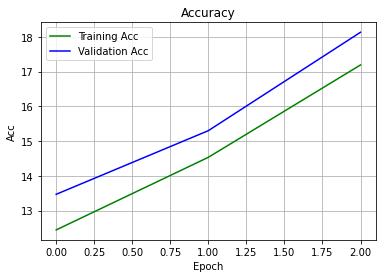

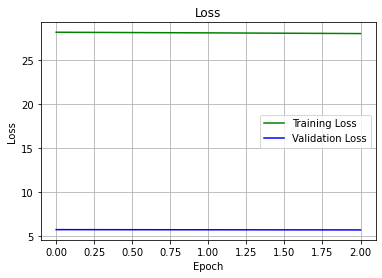

Test Accuracy: 18.24 %		Test Loss: 5.708458


In [ ]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

acc_test, loss_test = evaluate(dense, testloader, criterion) # CODE
print('Test Accuracy: %2.2f %%' % acc_test,
        'Test Loss: %2.6f' % loss_test,
        sep='\t\t')

### Tuned Performance

Vary any parameters you would like in the model's architecture (number of layers, hidden units, activation functions) or the training parameters (number of epochs, optimizer, learning rate, weight decay, momentum) to improve your initial performance. 

**Notes and requirements:** 
- The minimum acceptable test accuracy is 90%
- If you run your network multiple times it is possible to get very different results with each run. This is due to the random initializations.
- You are required to note down 5 significant changes you have experimented with and explain how these changes impacted your performance and your understanding as to why this is the case.
- Keep your best performing model / training method and create the same plots and testing performance from above. 

In [ ]:
class TunedDense(nn.Module):
    # What does your model contain
    def __init__(self):
        super().__init__()
        # CODE
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)

    
    # This is how data moves when passed to your model
    def forward(self, x):
        # CODE 
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

tuned_dense = TunedDense().to(device)

print("Model Architecture")
print(tuned_dense)
print("Number of parameters:", count_parameters(tuned_dense))

Model Architecture
TunedDense(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)
Number of parameters: 59210


In [ ]:
optimizer = optim.SGD(tuned_dense.parameters(), lr = .001, momentum = .9) # CODE
criterion = nn.CrossEntropyLoss() # CODE

train_acc, train_loss = [],[]
val_acc, val_loss = [],[]

print("Training on", device)
for epoch in range(10):
    
    acc_tr, loss_tr = train(tuned_dense, trainloader, criterion, optimizer)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    acc_v, loss_v = evaluate(tuned_dense, valloader, criterion)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

    print('Epoch %2d' % (epoch + 1),
            'Train Accuracy: %2.2f %%' % acc_tr,
            'Val Accuracy: %2.2f' % acc_v,
            sep='\t\t')

Training on cpu
Epoch  1		Train Accuracy: 21.32 %		Val Accuracy: 39.88
Epoch  2		Train Accuracy: 56.41 %		Val Accuracy: 74.22
Epoch  3		Train Accuracy: 80.19 %		Val Accuracy: 83.44
Epoch  4		Train Accuracy: 86.10 %		Val Accuracy: 87.80
Epoch  5		Train Accuracy: 88.99 %		Val Accuracy: 89.27
Epoch  6		Train Accuracy: 90.32 %		Val Accuracy: 89.97
Epoch  7		Train Accuracy: 91.06 %		Val Accuracy: 90.98
Epoch  8		Train Accuracy: 91.79 %		Val Accuracy: 91.45
Epoch  9		Train Accuracy: 92.39 %		Val Accuracy: 91.72
Epoch 10		Train Accuracy: 92.81 %		Val Accuracy: 92.41


Plot your peroformance using `plot_metrics` then evaluate your performance on the testloader / testset



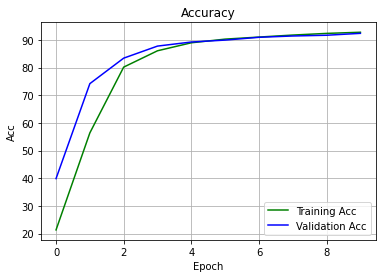

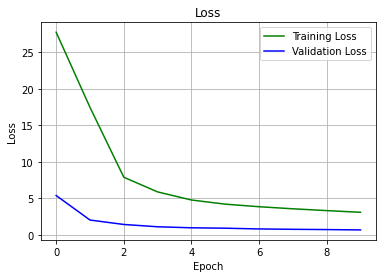

Test Accuracy: 92.89 %		Test Loss: 0.622753


In [ ]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

acc_test, loss_test = evaluate(tuned_dense, testloader, criterion) # CODE
print('Test Accuracy: %2.2f %%' % acc_test,
        'Test Loss: %2.6f' % loss_test,
        sep='\t\t')

**Experiementations and explainations:**

**`[double click here to add a solution]`**
1. The network is built to be multi layer so the compounding of all hidden layer functions via the chain rule retreive more features/patterns by each function per layer.
2. Activation functions are useful for applying nonlinearity to the linear compounded functions such that each hidden layer function may expect input of mean 0 and unit variance. ReLU is commonly chosen to gain universitality, allowing the functions to survive transformations. 
3. Log softmax is the last activation function where its input is the fully compounded dense network of 4 functions. Softmax is a generalized sigmoid which should be used as the final activation function in multi class problems.
4. Momentum of 0.9 is recommended via the pytorch optimization SGD section. Momentum of 0.0 performs just GD, where the results/epoch have a much longer training time because they use the entire dataset. 
5. The learning rate of .001 allows for accuracy to consistently increase, and for loss to continuously decrease, both stabilizing @10-12 epochs. The fact it experiences much more training loss than validation loss is because the validation model is not evaluated with added regularization. This is because the minimal amount of training data in SGD could be bettered by the added features gathered from regularization after backpropogation. With proper regularization, we may expect validation loss to be about equal to training loss.


## **Question 3:** Convolutional  Neural Networks



Using pytorch, build a 2d convolutional neural network with the following architecture.

1. 2D Convolution mapping the 1 x L x W input to 64 feature maps
2. 2D Convolution mapping the 64 x L x W features to 32 feature maps

3. Flatten the output
3. A dense layer mapping the flattened output to 16 nodes
4. A final dense layer mapping the 16 nodes to 10 classes

Each convolutional layer should be followed by a relu activation function then a 2D maxpool of `kernel_size` 2 and `stride` of 2

Each dense layer should be followed by a relu activation

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # CODE
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        #self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        #self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(32*7*7, 16)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(16,10)
        #self.relu4 = nn.ReLU()

    def forward(self, x):
        # CODE
        x = F.relu(self.conv1(x))
        #x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = F.relu(self.conv2(x))
        #x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = x.view(-1, 32*7*7)

        x = F.relu(self.fc1(x))
        #x = self.relu3(x)

        x = F.relu(self.fc2(x))
        #x = self.relu3(x)
        
        return x

cnn = CNN().to(device)

print("Model Architecture")
print(cnn)
print("Number of parameters:", count_parameters(cnn))

Model Architecture
CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=16, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)
Number of parameters: 44378


Complete the following code to train the network above for 10 epochs.
1. For your optimizer, use stochatic gradient descent (you may change this later if you would like)

2. For your criterion (loss function) use Cross Entropy Loss (the one built by pytorch)

**Notes and requirements:** 
- The minimum acceptable test accuracy is 90%
- If you run your network multiple times it is possible to get very different results with each run. This is due to the random initializations.
- You are welcome to experiment with the CNN architecture and anything else you want. You are required to experiment with different values for `learning_rate`, `momentum`, and `weight_decay` in your optimizer to improve your performance.
- Note down your experimentations and explain how these changes impacted your performance and your understanding as to why this is the case.
- Keep your best performing model / training method and create the same plots and testing performance as before.

In [ ]:
optimizer = optim.SGD(cnn.parameters(), lr = .05, momentum = .09, weight_decay = 0.005) # CODE
criterion = nn.CrossEntropyLoss() # CODE

train_acc, train_loss = [], []
val_acc, val_loss = [], []

print("Training on", device)
for epoch in range(10):
    
    acc_tr, loss_tr = train(cnn, trainloader, criterion, optimizer)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    acc_v, loss_v = evaluate(cnn, valloader, criterion)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

    print('Epoch %2d' % (epoch + 1),
            'Train Accuracy: %2.2f %%' % acc_tr,
            'Val Accuracy: %2.2f' % acc_v,
            sep='\t\t')

Training on cpu
Epoch  1		Train Accuracy: 84.17 %		Val Accuracy: 93.76
Epoch  2		Train Accuracy: 96.18 %		Val Accuracy: 96.85
Epoch  3		Train Accuracy: 96.95 %		Val Accuracy: 97.20
Epoch  4		Train Accuracy: 97.30 %		Val Accuracy: 96.99
Epoch  5		Train Accuracy: 97.66 %		Val Accuracy: 96.57
Epoch  6		Train Accuracy: 97.65 %		Val Accuracy: 92.86
Epoch  7		Train Accuracy: 97.72 %		Val Accuracy: 96.93
Epoch  8		Train Accuracy: 97.87 %		Val Accuracy: 97.85
Epoch  9		Train Accuracy: 97.95 %		Val Accuracy: 98.07
Epoch 10		Train Accuracy: 97.94 %		Val Accuracy: 97.93


Plot your peroformance using `plot_metrics` then evaluate your performance on the testloader / testset

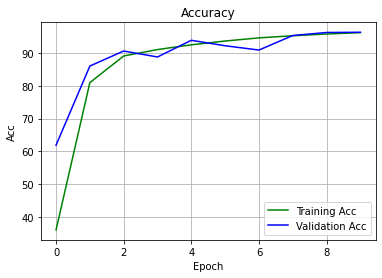

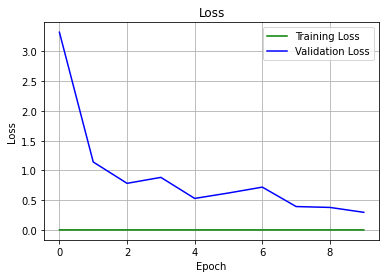

Test Accuracy: 96.77 %		Test Loss: 0.262668


In [ ]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

acc_test, loss_test = evaluate(cnn, testloader, criterion) # CODE
print('Test Accuracy: %2.2f %%' % acc_test,
        'Test Loss: %2.6f' % loss_test,
        sep='\t\t')

**Experiementations and explainations:**

**`[double click here to add a solution]`**

The weight decay proportional to the learning rate/epochs allows for larger improvement in the training/validation accuracy in epochs 1-3. Choosing the learning rate first to be small enough per the 10 epochs for optimal convergence, the randomness of SGD has worked by the provided .05 learning rate, weights decay of 0.9. 


## **Question 4:** Compare your results


Compare the cnn and dense networks your have built in terms of performance, runtime, accuracy, and any other factors you think are note worthy.

**Answer:**

**`[double click here to add a solution]`**
These CNN coefficients of activation functions lr=..05, weight decay=.005 influence the compounded expressions in the CNN algorithm to overfit the MNIST data more than a multi-layer perceptron. The training loss almost never has a value for the CNN, dropout/regularization or less complexity may make the training and validation loss as consistent as the MLP. The final accuracy of the CNN is appropriately higher than the multi-layer perceptron. Pre training all networks improve results per set of 10 epochs. Techniques such as dropout in both algorithms could improve accuracy and overfitting by randomly dropping nodes, accompanying the sparsity of SGD's samples. 
